In [ ]:
/content/drive/MyDrive/DL PROJECT /final dataset/BHSig260/Hindi

In [ ]:
%cd "/content/drive/MyDrive/DL PROJECT /final dataset/BHSig260/gray/"

/content/drive/MyDrive/DL PROJECT /final dataset/BHSig260/gray


In [ ]:
import cv2

import os,glob

from os import listdir,makedirs

from os.path import isfile,join
#path = '/content/drive/MyDrive/DL PROJECT /final dataset/BHSig260/Hindi/' # Source Folder
#dstpath = '/content/drive/MyDrive/DL PROJECT /final dataset/BHSig260/gray/' # Destination Folder

# Folder won't used

for i in range(1,161):
  path = '/content/drive/MyDrive/DL PROJECT /final dataset/BHSig260/Hindi/{:03d}'.format(i)
  dstpath = '/content/drive/MyDrive/DL PROJECT /final dataset/BHSig260/gray/{:03d}'.format(i)
  files = list(filter(lambda f: isfile(join(path,f)), listdir(path)))
  makedirs(dstpath)
  for image in files:
    try:
      img = cv2.imread(os.path.join(path,image))
      gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
      dstPath = join(dstpath,image)
      cv2.imwrite(dstPath,gray)
    except:
      print ("{} is not converted".format(image))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
import time
import itertools
import random

from sklearn.utils import shuffle

import tensorflow as tf
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate, Dropout
from keras.models import Model

#from tensorflow.keras.layers.normalization import BatchNormalization
#import tensorflow.keras.layers.BatchNormalization
from tensorflow.keras.layers import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform

from tensorflow.keras.layers import Layer, InputSpec
from keras.regularizers import l2
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    BatchNormalization, SeparableConv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
)
from tensorflow.keras import backend as K


In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
2.9118622189999996
GPU (s):
0.037720017999987476
GPU speedup over CPU: 77x


In [ ]:
import numpy as np
import pickle
import pandas as pd
from sklearn.metrics import accuracy_score
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import random
from scipy.spatial import distance
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

In [ ]:
path1 = "/content/drive/MyDrive/DL PROJECT /final dataset/BHSig260/gray/"
path = "/content/drive/MyDrive/DL PROJECT /final dataset/BHSig260/Hindi/"

In [ ]:
# Get the list of all directories and sort them
dir_list = next(os.walk(path))[1]
dir_list.sort()
dir_list1 = next(os.walk(path1))[1]
dir_list1.sort()

In [ ]:
# For each person segregate the genuine signatures from the forged signatures
# Genuine signatures are stored in the list "orig_groups"
# Forged signatures are stored in the list "forged_groups"
orig_groups, forg_groups = [], []
orig_groups_gray, forg_groups_gray = [], []
for directory in dir_list:
    images = os.listdir(path+directory)
    images.sort()
    images = [path+directory+'/'+x for x in images]
    forg_groups.append(images[:30]) # First 30 signatures in each folder are forrged
    orig_groups.append(images[30:]) # Next 24 signatures are genuine
for directory in dir_list1:
    images = os.listdir(path1+directory)
    images.sort()
    images = [path1+directory+'/'+x for x in images]
    forg_groups_gray.append(images[:30]) # First 30 signatures in each folder are forrged
    orig_groups_gray.append(images[30:]) # Next 24 signatures are genuine

In [ ]:
# Quick check to confirm we have data of all the 160 individuals
len(orig_groups), len(forg_groups)


(160, 160)

In [ ]:
len(orig_groups_gray), len(forg_groups_gray)

(160, 160)

In [ ]:
orig_lengths = [len(x) for x in orig_groups]
forg_lengths = [len(x) for x in forg_groups]
orig_lengths_gray = [len(x) for x in orig_groups_gray]
forg_lengths_gray = [len(x) for x in forg_groups_gray]

In [ ]:
# Quick check to confirm that there are 24 Genuine signatures for each individual
print(orig_lengths)

[24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24]


In [ ]:
print(orig_lengths_gray)

[24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24]


In [ ]:
# Quick check to confirm that there are 30 Forged signatures for each individual
print(forg_lengths)

[30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30]


In [ ]:
print(forg_lengths_gray)

[30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30]


#### Train-Validation-Test Split
* Signatures of 80 people are used for training
* Signatures of 20 people are used for validation
* Signatures of 20 people are used for testing

In [ ]:
orig_train, orig_val, orig_test = orig_groups[:80], orig_groups[80:100], orig_groups[100:120]
forg_train, forg_val, forg_test = forg_groups[:80], forg_groups[80:100], forg_groups[100:120]

In [ ]:
orig_train_gray, orig_val_gray, orig_test_gray = orig_groups_gray[:80], orig_groups_gray[80:100], orig_groups_gray[100:120]
forg_train_gray, forg_val_gray, forg_test_gray = forg_groups_gray[:80], forg_groups_gray[80:100], forg_groups_gray[100:120]

In [ ]:
# Delete unnecessary variables
del orig_groups, forg_groups
del orig_groups_gray, forg_groups_gray

In [ ]:
# All the images will be converted to the same size before processing
img_h, img_w = 155, 220

In [ ]:
def visualize_sample_signature():
    '''Function to randomly select a signature from train set and
    print two genuine copies and one forged copy'''
    fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize = (10, 10))
    k = np.random.randint(len(orig_train))
    j = np.random.randint(len(orig_train_gray))
    orig_img_names = random.sample(orig_train[k], 2)
    forg_img_name = random.sample(forg_train[k], 1)
    orig_img_gray_names = random.sample(orig_train_gray[j], 2)
    forg_img_gray_name = random.sample(forg_train_gray[j], 1)
    orig_img1 = cv2.imread(orig_img_names[0], 0)
    orig_img2 = cv2.imread(orig_img_names[1], 0)
    orig_img_gray_2 = cv2.imread(orig_img_gray_names[1], 0)
    orig_img_gray_1 = cv2.imread(orig_img_gray_names[0], 0)
    forg_img = plt.imread(forg_img_name[0], 0)
    forg_img_gray = plt.imread(forg_img_gray_name[0], 0)
    orig_img1 = cv2.resize(orig_img1, (img_w, img_h))
    orig_img2 = cv2.resize(orig_img2, (img_w, img_h))
    forg_img = cv2.resize(forg_img, (img_w, img_h))
    orig_img1 = cv2.resize(orig_img_gray_1, (img_w, img_h))
    orig_img2 = cv2.resize(orig_img_gray_2, (img_w, img_h))
    forg_img = cv2.resize(forg_img_gray, (img_w, img_h))

    ax1.imshow(orig_img1, cmap = 'gray')
    ax2.imshow(orig_img2, cmap = 'gray')
    ax3.imshow(forg_img, cmap = 'gray')
    ax4.imshow(orig_img_gray_1, cmap = 'gray')
    ax5.imshow(orig_img_gray_2, cmap = 'gray')
    ax6.imshow(forg_img_gray, cmap = 'gray')

    ax1.set_title('Genuine Copy')
    ax1.axis('off')
    ax2.set_title('Genuine Copy')
    ax2.axis('off')
    ax3.set_title('Forged Copy')
    ax3.axis('off')
    ax4.set_title('Genuine')
    ax4.axis('off')
    ax5.set_title('Genuine')
    ax5.axis('off')
    ax6.set_title('Forged')
    ax6.axis('off')

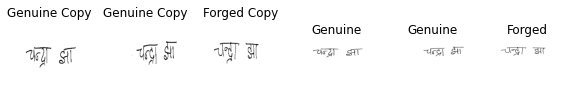

In [ ]:
visualize_sample_signature()

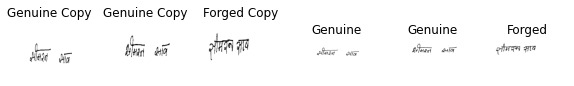

In [ ]:
visualize_sample_signature()

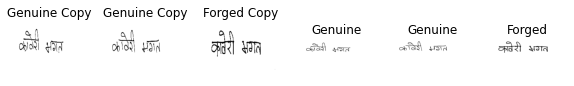

In [ ]:
visualize_sample_signature()

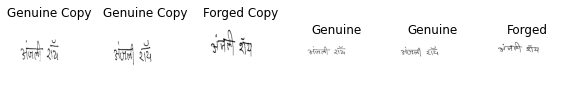

In [ ]:
visualize_sample_signature()

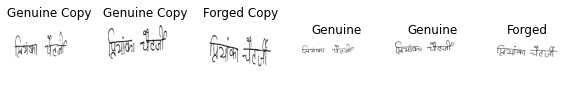

In [ ]:
visualize_sample_signature()

In [ ]:
def generate_batch(orig_groups, forg_groups,orig_groups_gray, forg_groups_gray, batch_size = 32):
    '''Function to generate a batch of data with batch_size number of data points
    Half of the data points will be Genuine-Genuine pairs and half will be Genuine-Forged pairs'''
    while True:
        orig_pairs = []
        forg_pairs = []
        orig_pairs_gray = []
        forg_pairs_gray = []
        gen_gen_labels = []
        gen_for_labels = []
        all_pairs = []
        all_labels = []
        all_gray = []
        # Here we create pairs of Genuine-Genuine image names and Genuine-Forged image names
        # For every person we have 24 genuine signatures, hence we have 
        # 24 choose 2 = 276 Genuine-Genuine image pairs for one person.
        # To make Genuine-Forged pairs, we pair every Genuine signature of a person
        # with 12 randomly sampled Forged signatures of the same person.
        # Thus we make 24 * 12 = 300 Genuine-Forged image pairs for one person. 24 * 10 = 240
        # In all we have 120 person's data in the training data.
        # Total no. of Genuine-Genuine pairs = 120 * 276 = 33120
        # Total number of Genuine-Forged pairs = 120 * 300 = 36000
        # Total no. of data points = 33120 + 36000 = 69120
        for orig, forg in zip(orig_groups, forg_groups):
            orig_pairs.extend(list(itertools.combinations(orig, 2)))
            for i in range(len(forg)):
                forg_pairs.extend(list(itertools.product(orig[i:i+1], random.sample(forg, 10))))
        for orig_gray, forg_gray in zip(orig_groups_gray, forg_groups_gray):
            orig_pairs_gray.extend(list(itertools.combinations(orig_gray, 2)))
            for i in range(len(forg_gray)):
                forg_pairs_gray.extend(list(itertools.product(orig_gray[i:i+1], random.sample(forg_gray, 10))))
        # Label for Genuine-Genuine pairs is 1
        # Label for Genuine-Forged pairs is 0
        gen_gen_labels = [1]*len(orig_pairs)
        gen_for_labels = [0]*len(forg_pairs)
        
        # Concatenate all the pairs together along with their labels and shuffle them
        all_pairs = orig_pairs + forg_pairs
        all_gray = orig_pairs_gray + forg_pairs_gray
        all_labels = gen_gen_labels + gen_for_labels
        del orig_pairs, forg_pairs, gen_gen_labels, gen_for_labels
        #all_pairs, all_labels = shuffle(all_pairs, all_labels)
        
        # Note the lists above contain only the image names and
        # actual images are loaded and yielded below in batches
        # Below we prepare a batch of data points and yield the batch
        # In each batch we load "batch_size" number of image pairs
        # These images are then removed from the original set so that
        # they are not added again in the next batch.
            
        k = 0
        pairs=[np.zeros((batch_size, img_h, img_w, 1)) for i in range(4)]
        targets=np.zeros((batch_size,))
        for ix, (pair,gray_pair) in enumerate(zip(all_pairs,all_gray)):
            img1 = cv2.imread(pair[0], 0)
            img2 = cv2.imread(pair[1], 0)
            img3 = cv2.imread(gray_pair[0], 0)
            img4 = cv2.imread(gray_pair[1], 0)
            img1 = cv2.resize(img1, (img_w, img_h))
            img2 = cv2.resize(img2, (img_w, img_h))
            img3 = cv2.resize(img3, (img_w, img_h))
            img4 = cv2.resize(img4, (img_w, img_h))
            img1 = np.array(img1, dtype = np.float64)
            img2 = np.array(img2, dtype = np.float64)
            img3 = np.array(img3, dtype = np.float64)
            img4 = np.array(img4, dtype = np.float64)
            img1 /= 255
            img2 /= 255
            img3 /= 255
            img4 /= 255
            img1 = img1[..., np.newaxis]
            img2 = img2[..., np.newaxis]
            img3 = img3[..., np.newaxis]
            img4 = img4[..., np.newaxis]
            pairs[0][k, :, :, :] = img1
            pairs[1][k, :, :, :] = img2
            pairs[2][k, :, :, :] = img3
            pairs[3][k, :, :, :] = img4
            targets[k] = all_labels[ix]
            k += 1
            if k == batch_size:
                yield pairs, targets
                k = 0
                pairs=[np.zeros((batch_size, img_h, img_w, 1)) for i in range(4)]
                targets=np.zeros((batch_size,))

In [ ]:
def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))

In [ ]:
def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [ ]:
def contrastive_loss(y_true, y_pred):
    
    margin = 1
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

In [ ]:
def create_base_network_signet(input_shape):
   
    seq = Sequential()
    seq.add(Conv2D(96, kernel_size=(11, 11), activation='relu', name='conv1_1', strides=4, input_shape= input_shape))
    seq.add(BatchNormalization(epsilon=1e-06, axis=1, momentum=0.9))
    seq.add(MaxPooling2D((3,3), strides=(2, 2)))    
    seq.add(ZeroPadding2D((2, 2)))
    
    seq.add(Conv2D(256, kernel_size=(5, 5), activation='relu', name='conv2_1', strides=1))
    seq.add(BatchNormalization(epsilon=1e-06, axis=1, momentum=0.9))
    seq.add(MaxPooling2D((3,3), strides=(2, 2)))
    seq.add(Dropout(0.3))# added extra
    seq.add(ZeroPadding2D((1, 1)))
    
    seq.add(Conv2D(384, kernel_size=(3, 3), activation='relu', name='conv3_1', strides=1))
    seq.add(ZeroPadding2D((1, 1)))
    
    seq.add(Conv2D(256, kernel_size=(3, 3), activation='relu', name='conv3_2', strides=1))    
    seq.add(MaxPooling2D((3,3), strides=(2, 2)))
    seq.add(Dropout(0.3))# added extra
    seq.add(Flatten(name='flatten'))
    seq.add(Dense(1024, activation='relu'))
    seq.add(Dropout(0.5))
    
    seq.add(Dense(128, activation='relu')) 
    
    return seq

In [ ]:
input_shape=(img_h, img_w, 1)

In [ ]:
# network definition
base_network = create_base_network_signet(input_shape)

input_a = Input(shape=(input_shape))
input_b = Input(shape=(input_shape))
input_c = Input(shape=(input_shape))
input_d = Input(shape=(input_shape))
processed_a = base_network(input_a)
processed_b = base_network(input_b)
processed_c = base_network(input_c)
processed_d = base_network(input_d)
distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([processed_a, processed_b])
distance_gray = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([processed_c, processed_d])
distances = tf.keras.layers.Add()([distance,distance_gray])
model = Model(inputs=[input_a, input_b,input_c, input_d], outputs=[distances])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 155, 220, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 155, 220, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_3 (InputLayer)           [(None, 155, 220, 1  0           []                               
                                )]                                                            

In [ ]:
base_network.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1_1 (Conv2D)            (None, 37, 53, 96)        11712     
                                                                 
 batch_normalization (BatchN  (None, 37, 53, 96)       148       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 18, 26, 96)       0         
 )                                                               
                                                                 
 zero_padding2d (ZeroPadding  (None, 22, 30, 96)       0         
 2D)                                                             
                                                                 
 conv2_1 (Conv2D)            (None, 18, 26, 256)       614656    
                                                        

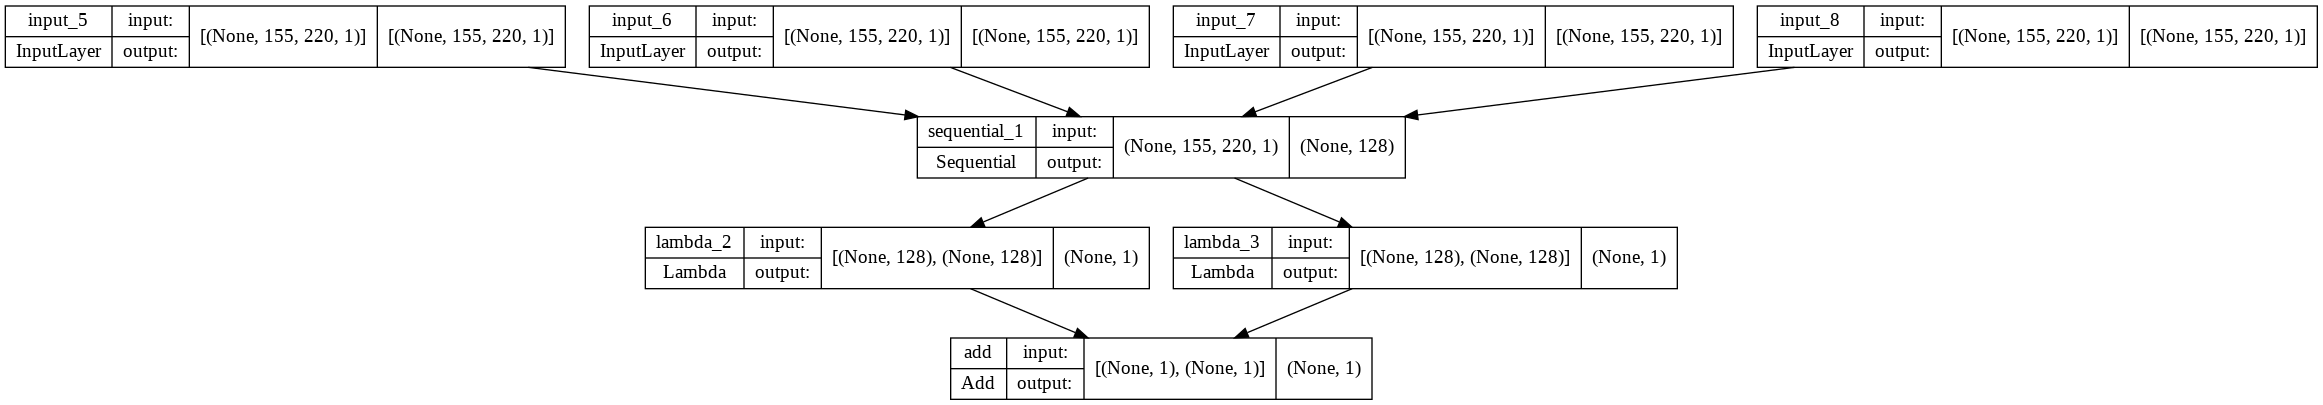

In [ ]:
from keras.models import Sequential
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True,show_layer_names=True)

In [ ]:
batch_sz = 128
num_train_samples = 276*40 + 240*40 
num_val_samples = num_test_samples = 276*10 + 240*10 
num_train_samples, num_val_samples, num_test_samples

(20640, 5160, 5160)

In [ ]:
from keras.optimizers import adam_v2
rms = adam_v2.Adam(learning_rate=0.001)
model.compile(loss=contrastive_loss, optimizer=rms)

In [ ]:
# Using Keras Callbacks, save the model after every epoch
# Reduce the learning rate by a factor of 0.1 if the validation loss does not improve for 5 epochs
# Stop the training using early stopping if the validation loss does not improve for 12 epochs
callbacks = [
    EarlyStopping(patience=3, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.000001, verbose=1),
    ModelCheckpoint('/content/drive/MyDrive/DL PROJECT /models/novel6-{epoch:03d}.h5', monitor='val_loss', verbose=1,save_best_only=True,save_weights_only=True,mode='min')
] #260-{epoch:03d}

#### After observing continuous fall in validation accuracy, I interrupted the training manually

In [ ]:
def compute_accuracy_roc(predictions, labels):
    '''Compute ROC accuracy with a range of thresholds on distances.
    '''
    dmax = np.max(predictions)
    dmin = np.min(predictions)
    nsame = np.sum(labels == 1)
    ndiff = np.sum(labels == 0)
   
    step = 0.01
    max_acc = 0
    best_thresh = -1
   
    for d in np.arange(dmin, dmax+step, step):
        idx1 = predictions.ravel() <= d
        idx2 = predictions.ravel() > d
       
        tpr = float(np.sum(labels[idx1] == 1)) / nsame       
        tnr = float(np.sum(labels[idx2] == 0)) / ndiff
        acc = 0.5 * (tpr + tnr)       
#       print ('ROC', acc, tpr, tnr)
       
        if (acc > max_acc):
            max_acc, best_thresh = acc, d
           
    return max_acc, best_thresh

#### Load the weights from the epoch which gave the best validation accuracy

In [ ]:
model.load_weights('/content/drive/MyDrive/DL PROJECT /models/novel5-003.h5')

In [ ]:
test_gen = generate_batch(orig_train, forg_train,orig_train_gray, forg_train_gray, 1)
pred, tr_y = [], []
for i in range(num_test_samples):
    (img1, img2,img3, img4), label = next(test_gen)
    tr_y.append(label)
    pred.append(model.predict([img1, img2,img3, img4])[0][0])

In [ ]:
tr_acc, threshold = compute_accuracy_roc(np.array(pred), np.array(tr_y))
tr_acc, threshold

(0.6697010869565218, 0.08133484799880535)

**Accuracy = 66.97% and Threshold = 0.08**





In [ ]:
def predict_score():
    '''Predict distance score and classify test images as Genuine or Forged'''
    test_point, test_label = next(test_gen)
    img1, img2, img3, img4 = test_point[0], test_point[1],test_point[2],test_point[3]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 10))
    ax1.imshow(np.squeeze(img1), cmap='gray')
    ax2.imshow(np.squeeze(img2), cmap='gray')
    ax2.imshow(np.squeeze(img3), cmap='gray')
    ax2.imshow(np.squeeze(img4), cmap='gray')
    ax1.set_title('Genuine')
    if test_label == 1:
        ax2.set_title('Genuine')
    else:
        ax2.set_title('Forged')
    ax1.axis('off')
    ax2.axis('off')
    plt.show()
    result = model.predict([img1, img2,img3,img4])
    diff = result[0][0]
    print("Difference Score = ", diff)
    if diff > threshold:
        print("Its a Forged Signature")
    else:
        print("Its a Genuine Signature")

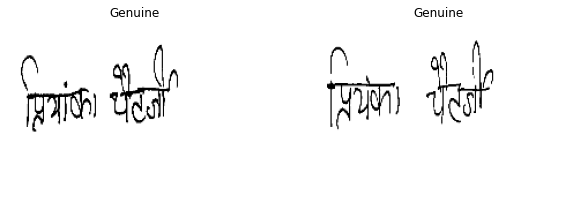

Difference Score =  0.12939754
Its a Forged Signature


In [ ]:
predict_score()

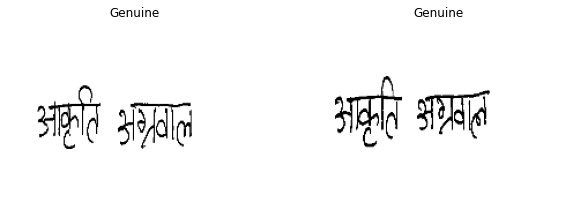

Difference Score =  0.014768401
Its a Genuine Signature


In [ ]:
predict_score()